# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [39]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

In [40]:
from importlib import reload  
from utils import util
util = reload(util)

In [41]:
# Set random seed for reproducibility
import warnings
warnings.filterwarnings("ignore")
seed = 84 #125 84 42 .... 23
util.fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [42]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [43]:
display(df)

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


In [44]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


### 1.2 Geographic plot of locations in northern Italy

In [45]:
# This split is just to make the geographic plot
#train_df, val_df, test_df = util.train_val_test_split(df, df_indexes_test)

In [46]:
# Run this cell only once to create the .tif file
'''from osgeo import gdal

# Definire i parametri di georeferenziazione dal file .jpgw
geotransform = [261600.0, 100.0, 0.0, 5296000.0, 0.0, -100.0]

# Aprire il file JPG originale con GDAL
ds = gdal.Open('Italia_tinitaly.jpg', gdal.GA_ReadOnly)

# Creare un driver TIFF per il salvataggio del file
driver = gdal.GetDriverByName('GTiff')

# Creare una copia del file originale, questa volta in formato TIFF
ds_tiff = driver.CreateCopy('Italia_tinitaly.tif', ds, 0)

# Assegnare il sistema di riferimento spaziale e la geotrasformazione al file TIFF
ds_tiff.SetProjection('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
ds_tiff.SetGeoTransform(geotransform)

# Salvare e chiudere i dataset
ds_tiff.FlushCache()
ds_tiff = None
ds = None'''


'from osgeo import gdal\n\n# Definire i parametri di georeferenziazione dal file .jpgw\ngeotransform = [261600.0, 100.0, 0.0, 5296000.0, 0.0, -100.0]\n\n# Aprire il file JPG originale con GDAL\nds = gdal.Open(\'Italia_tinitaly.jpg\', gdal.GA_ReadOnly)\n\n# Creare un driver TIFF per il salvataggio del file\ndriver = gdal.GetDriverByName(\'GTiff\')\n\n# Creare una copia del file originale, questa volta in formato TIFF\nds_tiff = driver.CreateCopy(\'Italia_tinitaly.tif\', ds, 0)\n\n# Assegnare il sistema di riferimento spaziale e la geotrasformazione al file TIFF\nds_tiff.SetProjection(\'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORIT

In [47]:
# import pandas as pd
# from PIL import Image, ImageDraw
# from osgeo import gdal

# # Carica l'immagine georeferenziata TIFF
# image_path = 'img/Italia_tinitaly.tif'
# image = Image.open(image_path)

# # Calcola le dimensioni dell'immagine
# width, height = image.size

# # Carica il file TIFF con GDAL per accedere alle informazioni georeferenziate
# ds = gdal.Open(image_path)

# # Ottieni la geotrasformazione dal dataset
# gt = ds.GetGeoTransform()

# def world_to_pixel(geo_matrix, x, y):
#     """
#     Usa la geotrasformazione del dataset per convertire le coordinate geografiche in coordinate pixel
#     """
#     ulX = geo_matrix[0]
#     ulY = geo_matrix[3]
#     xDist = geo_matrix[1]
#     yDist = geo_matrix[5]
#     rtnX = geo_matrix[2]
#     rtnY = geo_matrix[4]
#     pixel = int((x - ulX) / xDist)
#     line = int((ulY - y) / xDist)
#     return (pixel, line)

# # Crea un oggetto draw per disegnare sull'immagine
# draw = ImageDraw.Draw(image)

# # Imposta la dimensione del pallino per i punti
# #point_radius = 20

# # Definisci una funzione per disegnare i punti
# def draw_points(df, color):
#     for index, row in df.iterrows():
#         r = row['value_count']/10  # Raggio del cerchio basato sulla feature
#         pixel_coords = world_to_pixel(gt, row['X'], row['Y'])
#         draw.ellipse(
#             (pixel_coords[0] - r, pixel_coords[1] - r, 
#              pixel_coords[0] + r, pixel_coords[1] + r),
#             fill=color
#         )


# train_df['value_count'] = train_df.groupby('ID')['ID'].transform('count')       
# test_df['value_count'] = test_df.groupby('ID')['ID'].transform('count') 
 
# # Disegna i punti del train set in nero
# draw_points(train_df, 'black')     

# # Disegna i punti del test set in bianco
# draw_points(test_df, 'white')

# # Salva l'immagine modificata
# image.save('img/Italia_tinitaly_with_points.jpg')

# # Chiudi l'oggetto dataset di GDAL
# ds = None

### 1.3 Preprocess and split the dataset

In [48]:
# Standardize the data
df_std = util.standardize(df, 'gumbel')
# delete the column 'loc' and 'scale'
df_std = df_std.drop(['loc', 'scale'], axis=1, inplace=False)

In [49]:
df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,1.221239,28.250000,1.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.809340,4.673003,0.433955,-0.800952
1,5001.0,0.778761,28.250000,1.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.809340,4.673003,0.433955,-0.800952
2,5002.0,1.219018,33.469565,1.0,-0.005666,-0.495691,-0.502626,-0.492549,1.348947,1.486396,...,-1.100980,0.288846,-0.428899,-0.360315,1.047773,-0.366761,0.743587,-0.185967,-0.173545,-0.458485
3,5002.0,0.979995,33.469565,1.0,-0.005666,-0.495691,-0.502626,-0.492549,1.348947,1.486396,...,-1.100980,0.288846,-0.428899,-0.360315,1.047773,-0.366761,0.743587,-0.185967,-0.173545,-0.458485
4,5002.0,1.153287,33.469565,1.0,-0.005666,-0.495691,-0.502626,-0.492549,1.348947,1.486396,...,-1.100980,0.288846,-0.428899,-0.360315,1.047773,-0.366761,0.743587,-0.185967,-0.173545,-0.458485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338.0,0.918877,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146
274543,21338.0,0.950230,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146
274544,21338.0,0.602938,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146
274545,21338.0,0.877878,82.927273,24.0,-0.952079,-1.126887,-1.251321,-1.172944,-0.087441,0.158241,...,1.150926,-0.485886,0.460855,0.330387,-0.096756,-0.440846,-0.375587,-0.443614,0.933736,0.887146


In [50]:
# Split the dataset into train, validation and test
train_df_std, val_df_std, test_df_std = util.train_val_test_split(df_std, df_indexes_test)
min_AMS = train_df_std['AMS'].min()
max_AMS = train_df_std['AMS'].max()

train_df_std = util.scale_AMS(train_df_std, min_AMS, max_AMS) 
val_df_std = util.scale_AMS(val_df_std, min_AMS, max_AMS) 
test_df_std = util.scale_AMS(test_df_std, min_AMS, max_AMS) 

In [51]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [52]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.162028,28.25,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.103407,28.25,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,0.146866,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.118569,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,0.157156,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [53]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.132718,57.047139,9.196126,0.024646,0.032570,0.042734,0.047496,0.014040,0.013421,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.049723,31.055424,8.279490,0.984392,0.986320,0.981766,0.976423,1.004977,1.008808,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.001325,5.200000,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,-4.369229,-3.522613,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.099157,34.977778,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,-0.578875,-0.620972,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.123613,49.674286,6.000000,-0.264208,-0.091967,0.073687,0.116867,0.016296,0.066203,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,0.155474,70.343750,12.000000,0.480086,0.640557,0.730073,0.713190,0.644833,0.693127,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,0.833372,318.742857,24.000000,5.244876,3.734721,2.928541,3.520526,3.648847,2.935948,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


In [54]:
def add_loc_scale(df):
 
    # create two empy columns for alpha and beta
    df['loc'] = np.nan
    df['scale'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
            
            if len(ams) < 2:
                loc, scale = np.nan, np.nan
            else:
                loc, scale = stats.gumbel_r.fit(ams)   
                        
            df.loc[condition, 'loc'] = loc
            df.loc[condition, 'scale'] = scale
 
    df.dropna(inplace=True)
 
    return df

In [55]:
test_df_std = add_loc_scale(test_df_std)
#train_df_std = add_loc_scale(train_df_std)
#val_df_std = add_loc_scale(val_df_std)

### 1.4 Loc and scale inspection

In [18]:
#util.geographic_plot(train_df_std, 'loc', 'scale')

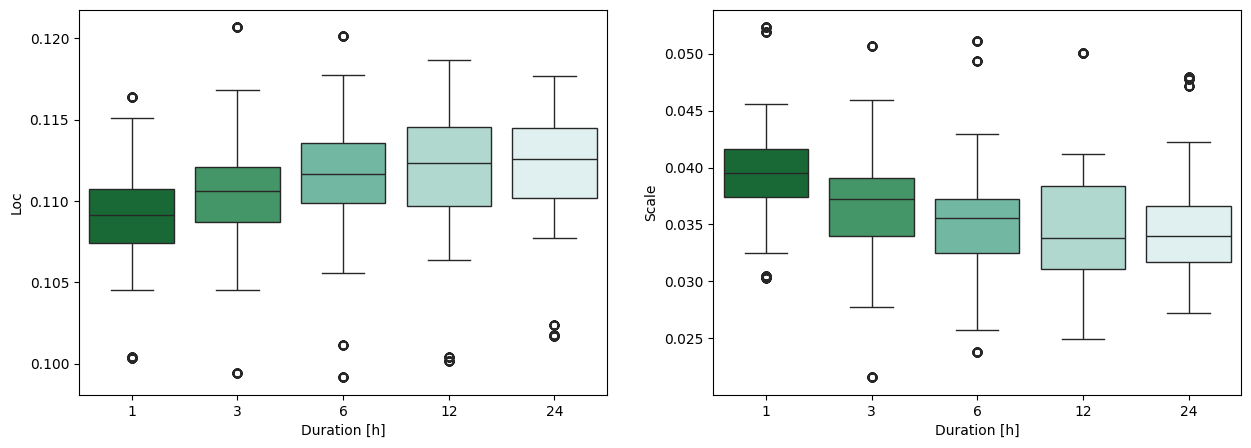

In [19]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#sns.set(rc={'axes.facecolor': '#071C42', 'figure.facecolor': '#071C42', 'text.color':'white'})

#ALPHA
sns.boxplot(x='duration[h]', y='loc', data=test_df_std, ax=ax[0], palette='BuGn_r')

# Set both x and y axis color to white
ax[0].tick_params(axis='x')
ax[0].tick_params(axis='y')

# Set axes titles color to white
ax[0].set_xlabel("Duration [h]")
ax[0].set_ylabel("Loc")

#BETA
sns.boxplot(x='duration[h]', y='scale', data=test_df_std, ax=ax[1], palette='BuGn_r')

ax[1].tick_params(axis='x')
ax[1].tick_params(axis='y')

# Set axes titles color to white
ax[1].set_xlabel("Duration [h]")
ax[1].set_ylabel("Scale")

plt.show()

In [20]:
sns.reset_defaults()

In [57]:
# Create a dataframe with the count of AMS values for each ID and duration
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = test_df_std.groupby(['ID','duration[h]'])['loc'].mean()
AMS_count['scale'] = test_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5005 1               64  0.109630  0.037899
     3               64  0.109951  0.037229
     6               64  0.110515  0.035955
     12              64  0.111238  0.036457
     24              64  0.112343  0.034367
5007 1               20  0.110742  0.037979
     3               20  0.105514  0.043845
     6               20  0.108555  0.040624
     12              20  0.113861  0.034812
     24              20  0.116839  0.029910
5015 1               76  0.113908  0.033347
     3               76  0.116801  0.027721
     6               77  0.116926  0.027284
     12              78  0.116549  0.026957
     24              77  0.115250  0.029387

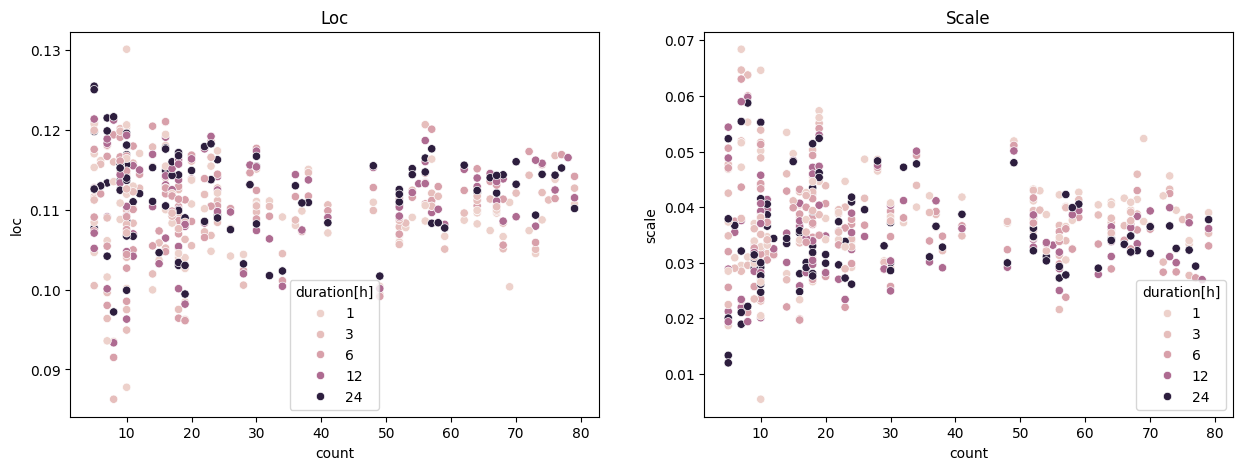

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

### 1.5 Prepare data for training

In [59]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [60]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [61]:
# create a dictionary to store for each duration and for each ID the AMS values
# this will be used to make the ks-test 
AMS_dict_test = {}
for duration in DURATION:
    AMS_dict_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].groupby('ID')['AMS'].apply(list).to_dict()


In [62]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
input_columns_train = train_df_std.columns[3:] 
input_columns_test = ['ID'] +list(test_df_std.columns[3:-2]) #use also ID to retrieve loc and scale
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns_train)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [63]:
inputs_train = train_df_std[input_columns_train]
outputs_train = train_df_std[output_column]
#parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns_train]
outputs_val = val_df_std[output_column]
#parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns_test]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [64]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
2,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
4,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233213,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233214,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233215,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233216,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0


In [65]:
# Inputs to train a model with only MAP and duration

inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.185839,1,0,0,0,0
1,2.185839,1,0,0,0,0
2,2.185839,0,1,0,0,0
3,2.185839,0,1,0,0,0
4,2.185839,0,1,0,0,0
...,...,...,...,...,...,...
233213,-0.125310,0,0,1,0,0
233214,-0.125310,0,0,1,0,0
233215,-0.125310,0,0,1,0,0
233216,-0.125310,0,0,1,0,0


In [66]:
# Inputs to train a model after applying PCA

inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test[inputs_test.columns[1:]], 5)

inputs_train_pca

,0,1,2,3,4
0,4.122811,-0.393489,-0.708271,5.286254,0.040014
1,4.122811,-0.393489,-0.708271,5.286254,0.040014
2,4.122848,-0.393510,-0.708254,5.286419,0.040041
3,4.122848,-0.393510,-0.708254,5.286419,0.040041
4,4.122848,-0.393510,-0.708254,5.286419,0.040041
...,...,...,...,...,...
233213,5.980432,1.973444,2.164320,-0.433018,0.024112
233214,5.980432,1.973444,2.164320,-0.433018,0.024112
233215,5.980432,1.973444,2.164320,-0.433018,0.024112
233216,5.980432,1.973444,2.164320,-0.433018,0.024112


## 2. Model definition

In [31]:
def build_nn_gumbel_model(input_shape, hidden, seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    
    mu_logsig = layers.Dense(2, activation='linear',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

## 3. Training

### 3.1  MAP-model

In [32]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [33]:
# Hyperparameters for training
hidden_layers = [256,128]
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.5238 - val_loss: -1.6072
Epoch 2/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6713 - val_loss: -1.7350
Epoch 3/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6873 - val_loss: -1.7066
Epoch 4/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.6939 - val_loss: -1.7222
Epoch 5/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.7008 - val_loss: -1.2978
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6876 - val_loss: -1.7605
Epoch 7/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.7059 - val_loss: -1.7392
Epoch 8/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.7071 - val_loss: -1.7584
Epoch 9/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.7072 - val_loss: -1.7567
Epoch 10/90
1823/

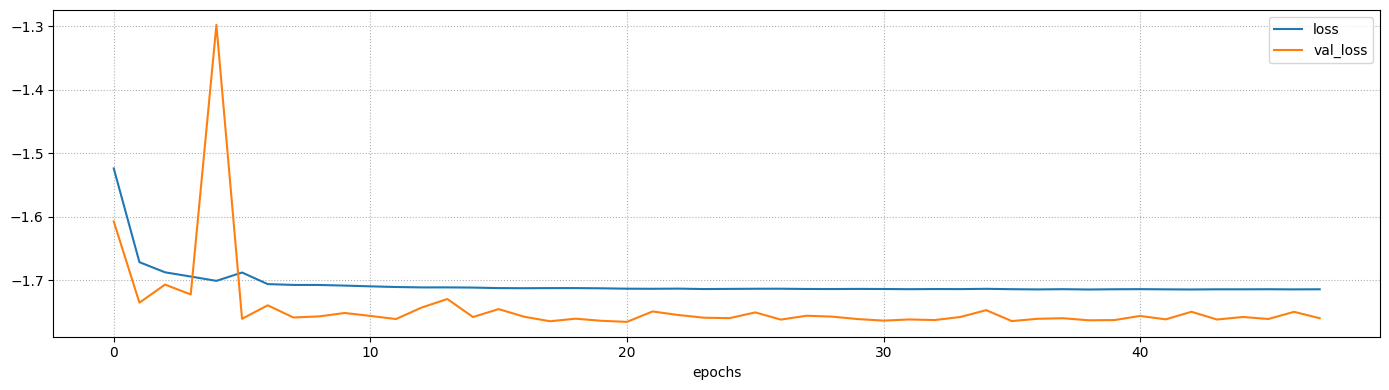

Final loss: -1.7140 (training), -1.7595 (validation)


In [34]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=hidden_layers, seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.4280 - val_loss: -1.4169
Epoch 2/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6750 - val_loss: -1.6519
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7004 - val_loss: -1.7106
Epoch 4/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.7070 - val_loss: -1.7455
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7125 - val_loss: -1.4638
Epoch 6/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.7048 - val_loss: -1.7362
Epoch 7/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.7184 - val_loss: -1.7251
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7195 - val_loss: -1.7541
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7207 - val_loss: -1.7626
Epoch 

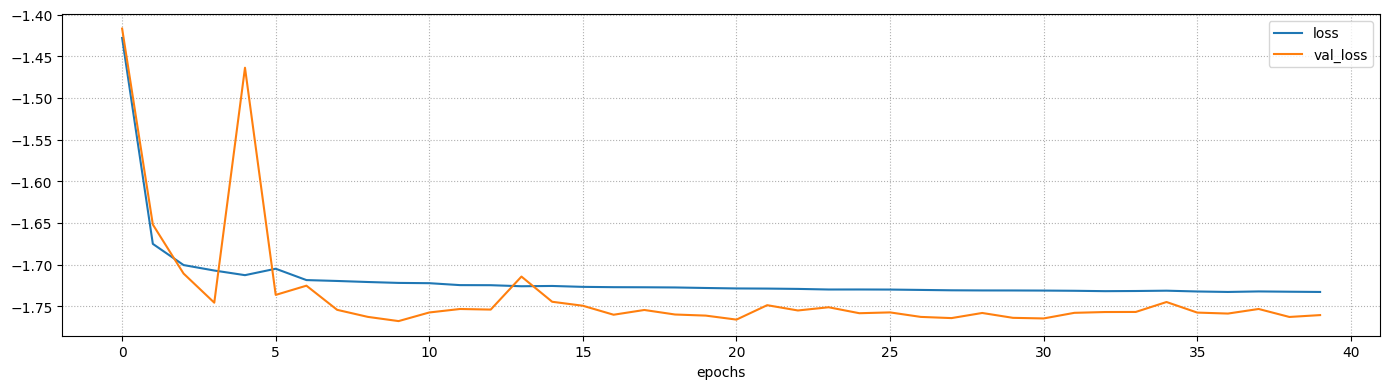

Final loss: -1.7327 (training), -1.7604 (validation)


In [34]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test[inputs_test.columns[1:]].values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3 PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.1378 - val_loss: -0.9497
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6418 - val_loss: -1.7021
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6868 - val_loss: -1.6998
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7013 - val_loss: -1.7453
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7088 - val_loss: -1.4476
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6960 - val_loss: -1.7532
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7140 - val_loss: -1.7500
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7144 - val_loss: -1.7487
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.7148 - val_loss: -1.

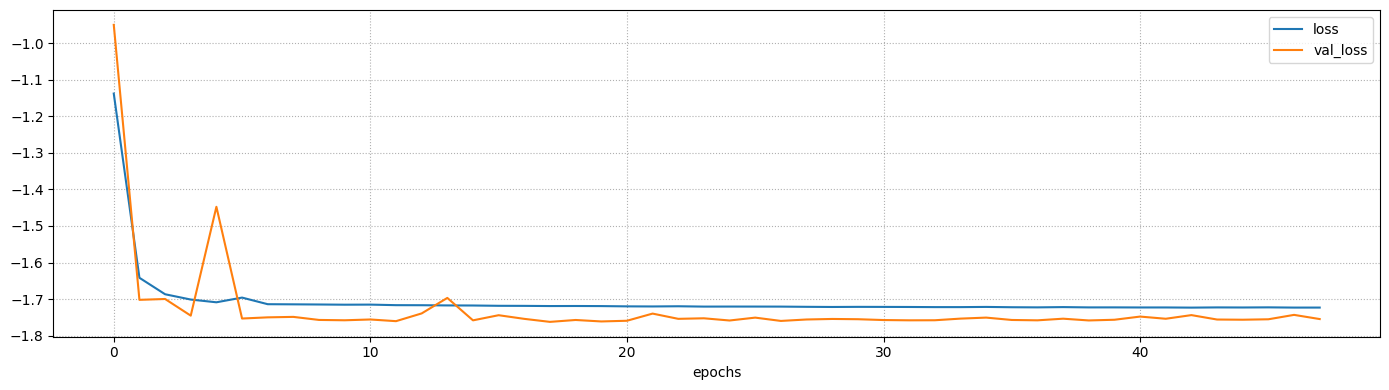

Final loss: -1.7233 (training), -1.7547 (validation)


In [36]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Predictions

In [37]:
dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)

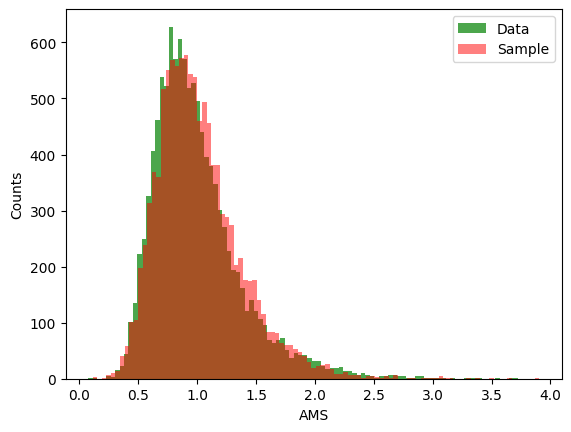

In [38]:
y_test_rescaled = util.inverse_scale_AMS(y_test, min_AMS, max_AMS)

y_pred = dist_test_full.sample(1).numpy().ravel()
y_pred_rescaled = util.inverse_scale_AMS(y_pred, min_AMS, max_AMS)

util.plot_hist_samples(y_test_rescaled, y_pred_rescaled, 'red')

### 4.1 Confidence interval 

In [39]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


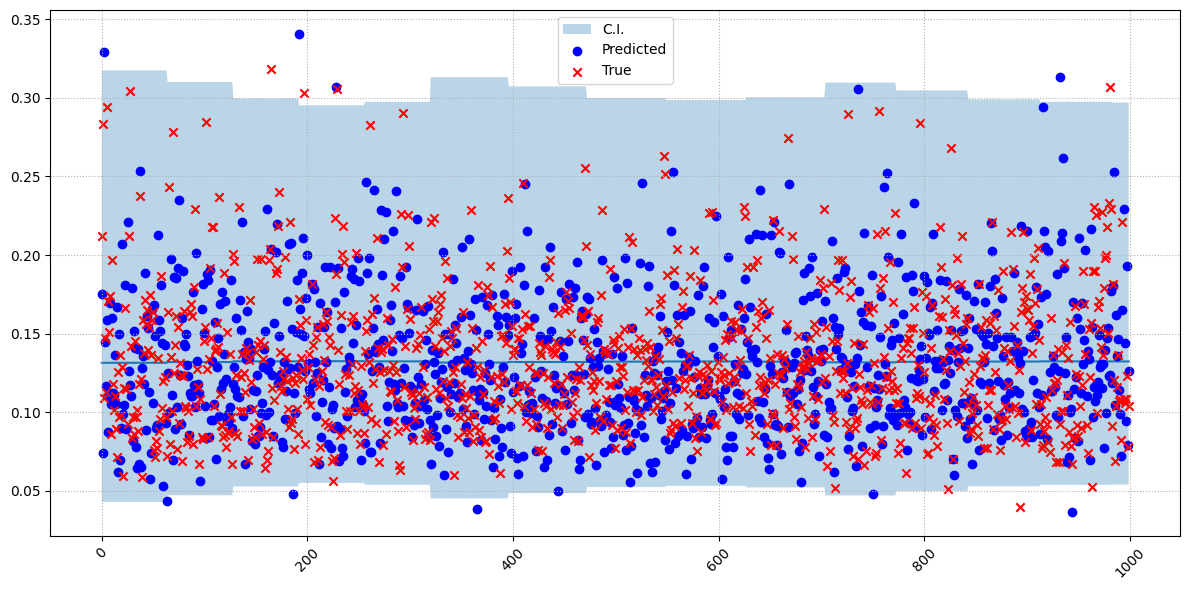

Percentage of values inside the 99% confidence interval: 98.58%


In [40]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


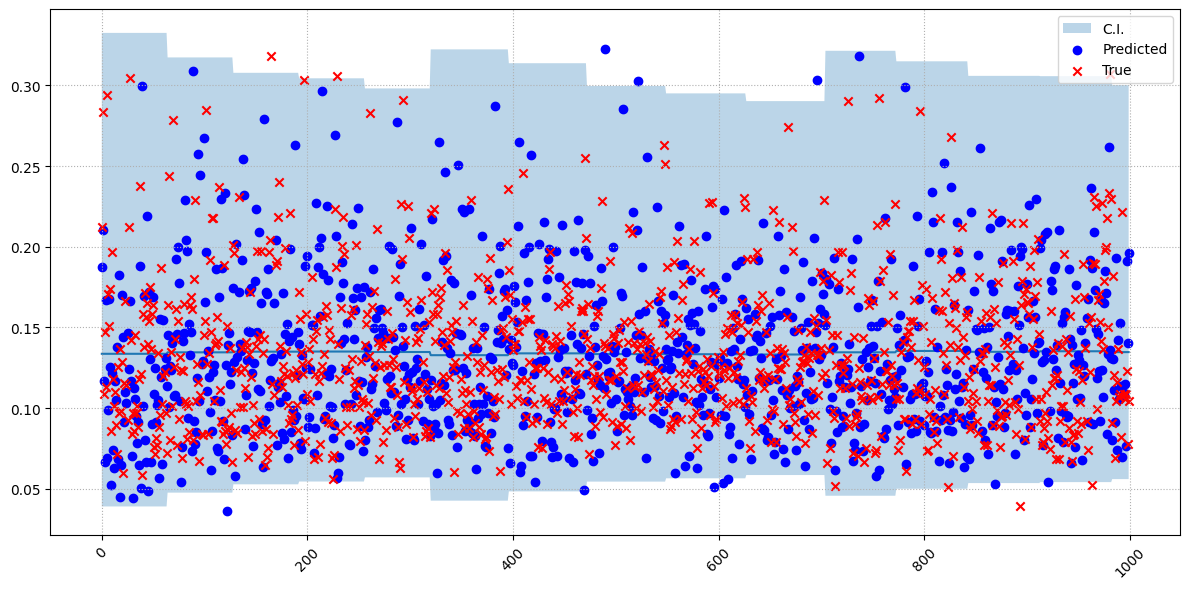

Percentage of values inside the 99% confidence interval: 98.71%


In [41]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


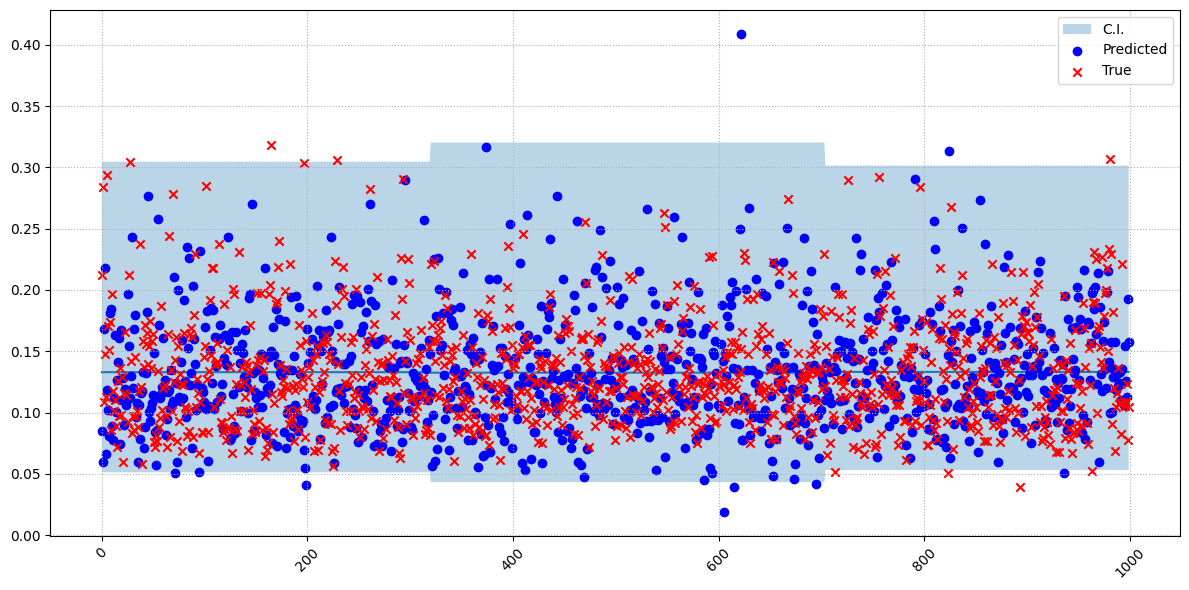

Percentage of values inside the 99% confidence interval: 98.58%


In [42]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters metrics

Metrics on parameters from MAP-model

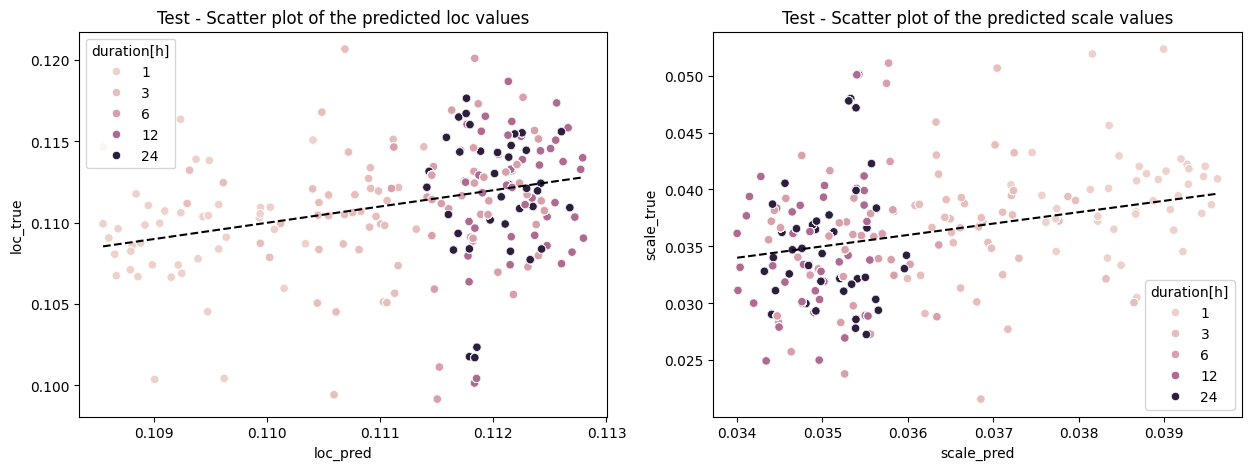

In [43]:
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [44]:
print('=============== LOC PARAMETER===============')
display(metrics_loc_map)
print('===============SCALE PARAMETER==============')
metrics_scale_map

=============== LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.002412,-0.002567,-0.002994,-0.003840,-0.003442,0.000789
mape,0.024291,0.021454,0.024011,0.025811,0.025607,0.024573
pcc,0.306921,0.117635,-0.049204,0.105506,0.155732,0.033502


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.020844,0.012669,-0.028040,-0.027689,-0.027075,-0.034132
mape,0.107936,0.081414,0.108813,0.115016,0.125059,0.109392
pcc,0.360083,0.118559,-0.055152,0.151204,0.194955,0.032803


Metrics on parameters from Full-model

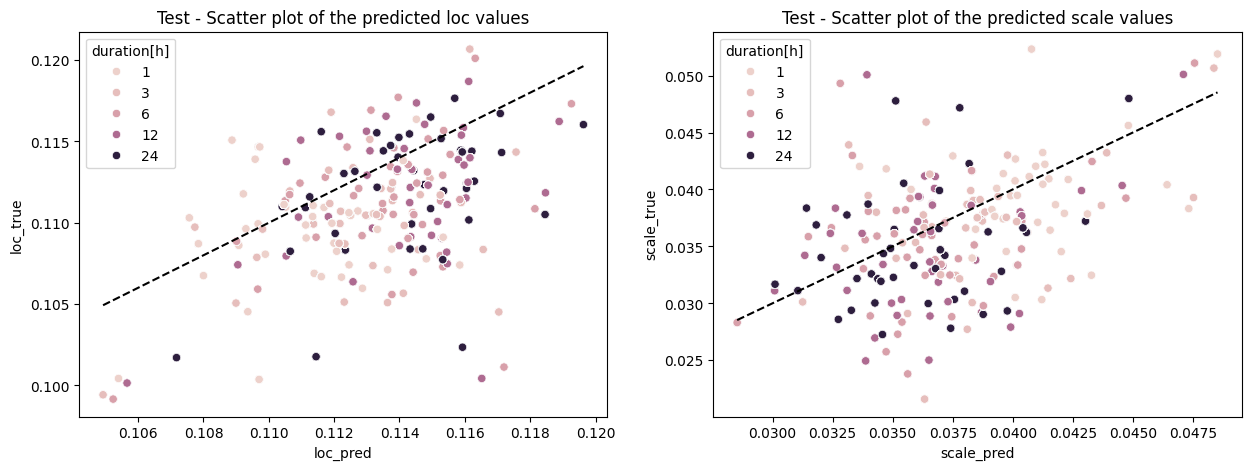

In [45]:
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_full, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [46]:
print('===============LOC PARAMETER===============')
display(metrics_loc_full)
print('===============SCALE PARAMETER ==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.021804,-0.022045,-0.024034,-0.021227,-0.021074,-0.020637
mape,0.030024,0.031112,0.032344,0.028855,0.030341,0.027464
pcc,0.464058,0.236626,0.406492,0.455066,0.392166,0.420137


===============SCALE PARAMETER ==============


,global,1,3,6,12,24
biasr,-0.054629,-0.034099,-0.056944,-0.058739,-0.071604,-0.051764
mape,0.116903,0.096973,0.109892,0.121113,0.134451,0.122102
pcc,0.431805,0.189450,0.366028,0.390902,0.336196,0.272473


Metrics on parameters from PCA-model

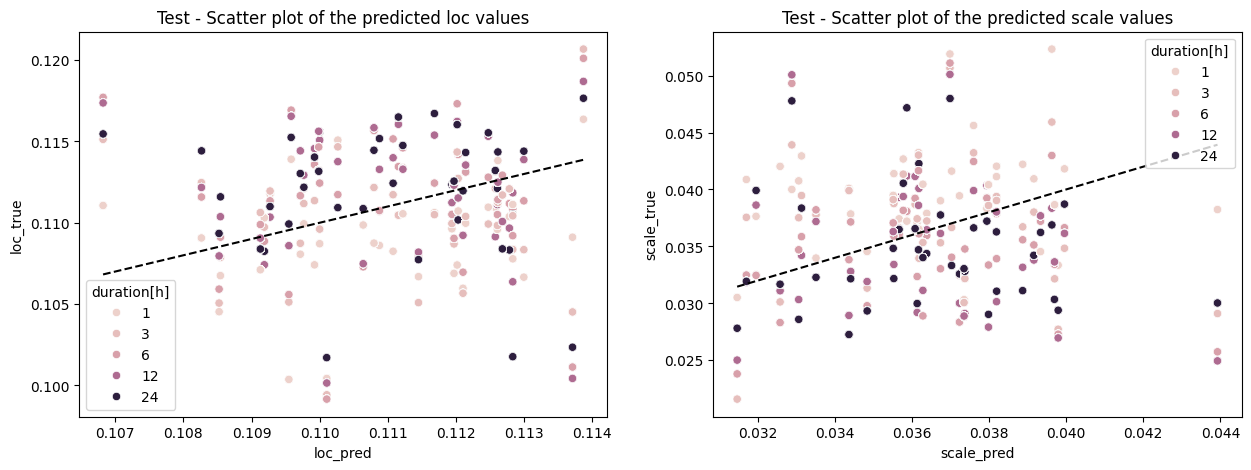

In [47]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [48]:
print('===============LOC PARAMETER===============')
display(metrics_loc_pca)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.001411,-0.019187,-0.006769,0.003233,0.006825,0.008869
mape,0.027878,0.028744,0.026476,0.027888,0.028488,0.027791
pcc,0.097084,0.259375,0.118325,0.130009,0.008784,0.007268


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.054629,-0.034099,-0.056944,-0.058739,-0.071604,-0.051764
mape,0.116903,0.096973,0.109892,0.121113,0.134451,0.122102
pcc,0.431805,0.189450,0.366028,0.390902,0.336196,0.272473


### 5.1  Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc: 0.11, Predicted loc: 0.11
True scale: 0.04, Predicted scale: 0.04
KS statistics:  0.0379
p-value:  1.1523872600898962e-06


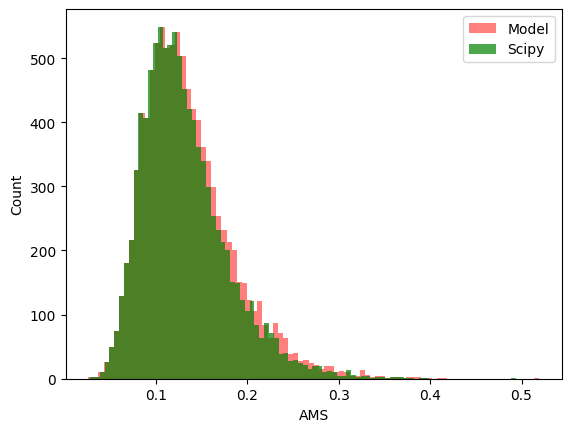

In [49]:
# Anzola dell'Emilia -> index 9252
util.compare_samples(dist_test_full, "gumbel", parameters_test, seed = seed, index=9252)

True loc: 0.12, Predicted loc: 0.11
True scale: 0.03, Predicted scale: 0.04
KS statistics:  0.0656
p-value:  3.974512508267744e-19


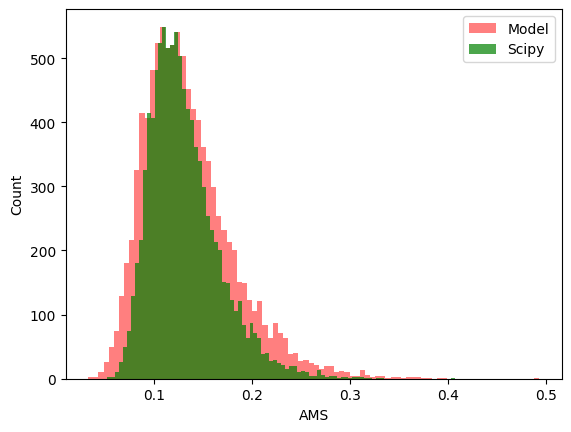

In [50]:
# Viganego -> index 10575
util.compare_samples(dist_test_full, "gumbel", parameters_test, seed = seed, index=10575)

### neg log like

In [51]:
loc, scale, ams = test_df_std[['loc', 'scale', 'AMS']].values.T
dist = tfp.distributions.Gumbel(loc = loc, scale = scale)
losses = -dist.log_prob(ams)
loss_full_scipy = np.mean(losses)

print(loss_full_scipy)

-1.7342187708567554


In [52]:
# FULL
loss_full_pred = full_model.evaluate(X_test, y_test)
print(loss_full_pred)

  1/353 [..............................] - ETA: 9s - loss: -1.5301

353/353 [==============================] - 0s 1ms/step - loss: -1.7055
-1.7054758071899414


In [53]:
# MAP
loss_map_pred = map_model.evaluate(X_test_map, y_test)
print(loss_map_pred)

  1/353 [..............................] - ETA: 9s - loss: -1.5277

353/353 [==============================] - 0s 1ms/step - loss: -1.7074
-1.7074159383773804


In [54]:
# PCA
loss_pca_pred = pca_model.evaluate(X_test_pca, y_test)
print(loss_pca_pred)

 30/353 [=>............................] - ETA: 0s - loss: -1.7873

353/353 [==============================] - 1s 1ms/step - loss: -1.7004
-1.7004064321517944


## 6. KS statistic

In [35]:
loc_dict_pred, scale_dict_pred = util.parameters_to_dict(inputs_test, 'gumbel', full_model, DURATION)

In [36]:
ks_stat_gumbel, p_value_gumbel = util.KS_statistic(AMS_dict_test, loc_dict_pred, scale_dict_pred, 'gumbel', DURATION)

In [37]:
# Create a dataframe containing the statistic for each ID and duration
data_ks = []
for duration in DURATION:
    for id in ks_stat_gumbel[duration].keys():
        ks_statistic_pred_value = ks_stat_gumbel[duration][id]
        p_value_pred = p_value_gumbel[duration][id]
        data_ks.append((duration, id, ks_statistic_pred_value, p_value_pred))


df_ks = pd.DataFrame(data_ks, columns=['duration', 'ID', 'ks_statistic_gumbel', 'p_value_gumbel'])
df_ks.to_pickle('results/ks_gumbel.pkl')

## 7. Save results 


In [125]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_scale_map, metrics_scale_full, metrics_scale_pca]

In [126]:
scale_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
scale_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.020844,-0.054629,-0.027020,0.107936,0.116903,0.126778,0.360083,0.431805,0.055003
1,0.012669,-0.034099,0.073081,0.081414,0.096973,0.110721,0.118559,0.189450,0.185109
3,-0.028040,-0.056944,-0.009691,0.108813,0.109892,0.121313,-0.055152,0.366028,0.096313
6,-0.027689,-0.058739,-0.057943,0.115016,0.121113,0.129002,0.151204,0.390902,0.084981
12,-0.027075,-0.071604,-0.070936,0.125059,0.134451,0.142743,0.194955,0.336196,-0.045543
24,-0.034132,-0.051764,-0.069743,0.109392,0.122102,0.130121,0.032803,0.272473,-0.013146


In [127]:
models_metrics = [ metrics_loc_map, metrics_loc_full, metrics_loc_pca]
loc_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
loc_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.002412,-0.021804,-0.001411,0.024291,0.030024,0.027878,0.306921,0.464058,0.097084
1,-0.002567,-0.022045,-0.019187,0.021454,0.031112,0.028744,0.117635,0.236626,0.259375
3,-0.002994,-0.024034,-0.006769,0.024011,0.032344,0.026476,-0.049204,0.406492,0.118325
6,-0.003840,-0.021227,0.003233,0.025811,0.028855,0.027888,0.105506,0.455066,0.130009
12,-0.003442,-0.021074,0.006825,0.025607,0.030341,0.028488,0.155732,0.392166,0.008784
24,0.000789,-0.020637,0.008869,0.024573,0.027464,0.027791,0.033502,0.420137,0.007268


In [128]:
#export as pkl file  loc and scale metrics
loc_metrics.to_pickle('results/loc_metrics.pkl')
scale_metrics.to_pickle('results/scale_metrics.pkl')
